$\newcommand{\TirName}[1]{\text{#1}}
\newcommand{\inferrule}[3][]{
  \let\and\qquad
  \begin{array}{@{}l@{}}
  \TirName{#1}
  \\
  \displaystyle
  \frac{#2}{#3}
  \end{array}
}
\newcommand{\infer}[3][]{\inferrule[#1]{#2}{#3}}
$

# Meeting 09 - Static Scoping

Bor-Yuh Evan Chang  
Tuesday, September 24, 2024

<!-- 3 Expressions -->

<!-- 4 Binding and Scope -->

<!-- 8 Recursion -->

<!-- 9 Inductive Data Types -->

<!-- 11 Concrete Syntax -->

<!-- 12 Abstract Syntax and Parsing -->

<!-- 13 Exercise: Syntax -->

<!-- 14 Static Scoping -->

<!-- 15 Judgments -->

<!-- 16 Variables, Basic Values, and Judgments Lab -->

<!-- 18 Operational Semantics -->

<!-- 19 Functions and Dynamic Scoping -->

<!-- 20 Big-Step Exercise -->

<!-- 21 Evaluation Order  -->

<!-- 26 Static Type Checking -->

<!-- 27 Lazy Evaluation -->

<!-- 28 Objects -->

<!-- 28 Static Type Checking Lab -->

<!-- 30 Mutable State -->

<!-- Encapsulating Effects Exercise -->

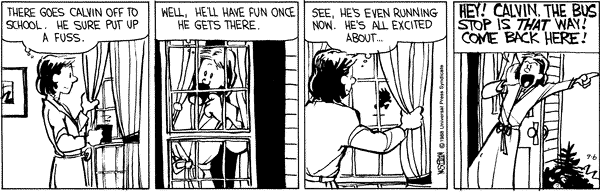

What questions does your neighbor have?

[ In-Class Slides](in-class/meeting09-static-scoping.pdf)<br/> [
In-Class Jupyter](in-class/meeting09-static-scoping.ipynb)<br/> [ Book
Chapter](https://csci3155.cs.colorado.edu/pppl-course/book/static-scoping.html)

## Announcements

-   Lab 2 due this Friday (or Monday?) 6pm

## Today

-   Preview Lab 2
-   [Static
    Scoping](https://csci3155.cs.colorado.edu/pppl-course/book/static-scoping.html)
-   Triage Your Questions
    -   Using VSCode or the terminal to test your code (on
        coding.csel.io)?
    -   Auto-testing with GitHub Actions?
    -   HW2?

## Questions?

-   Review:
    -   How does a *recursive-descent parser* work, roughly?

## Questions?

## Review: Variable Binding and Scope

What’s variable binding?





What’s variable scope?

## Variable Binding

How do you bind a variable in Scala?





In JavaScript?

## JavaScripty

Let’s extend our abstract syntax type `Expr`.

In [2]:
sealed trait Expr

defined trait Expr

``` scala
sealed trait Expr                                                // e ::=
case class N(n: Double) extends Expr                             //   n
case class Plus(e1: Expr, e2: Expr) extends Expr                 // | e1 + e2
case class Var(x: String) extends Expr                           // | x
case class ConstDecl(x: String, e1: Expr, e2: Expr) extends Expr // | const x = e1; e2
```

<pre>defined <span class="ansi-green-fg">trait</span> <span class="ansi-cyan-fg">Expr</span>
defined <span class="ansi-green-fg">class</span> <span class="ansi-cyan-fg">N</span>
defined <span class="ansi-green-fg">class</span> <span class="ansi-cyan-fg">Plus</span>
defined <span class="ansi-green-fg">class</span> <span class="ansi-cyan-fg">Var</span>
defined <span class="ansi-green-fg">class</span> <span class="ansi-cyan-fg">ConstDecl</span></pre>

**Ask:** What’s the scope of a variable binding in this representation?

## Free Variables

Let’s define a function to compute the free variables of a JavaScripty
expression:

In [4]:
def freeVars(e: Expr): Set[String] = ???

defined function freeVars

In [5]:
val e_n = N(2)
val e_plusnn = Plus(e_n, e_n)
val e_var = Var("four")
val e_plusvarvar = Plus(e_var, e_var)
val e_constdecl = ConstDecl("four", e_plusnn, e_plusvarvar)

e_n : N = N (n = 2.0 )
 e_plusnn : Plus = Plus (e1 = N (n = 2.0 ), e2 = N (n = 2.0 ))
 e_var : Var = Var (x = "four" )
 e_plusvarvar : Plus = Plus (e1 = Var (x = "four" ), e2 = Var (x = "four" ))
 e_constdecl : ConstDecl = ConstDecl (
 x = "four" ,
 e1 = Plus (e1 = N (n = 2.0 ), e2 = N (n = 2.0 )),
 e2 = Plus (e1 = Var (x = "four" ), e2 = Var (x = "four" ))
)

``` scala
def freeVars(e: Expr): Set[String] = e match {
  case N(_) => Set.empty
  case Plus(e1, e2) => freeVars(e1) union freeVars(e2)
  case Var(x)  => Set(x)
  case ConstDecl(x, e1, e2) => freeVars(e1) union (freeVars(e2) - x)
}
```

<pre>defined <span class="ansi-green-fg">function</span> <span class="ansi-cyan-fg">freeVars</span></pre>

``` scala
val fv_n = freeVars(e_n)
val fv_plusnn = freeVars(e_plusnn)
val fv_var = freeVars(e_var)
val fv_plusvarvar = freeVars(e_plusvarvar)
val fv_constdecl = freeVars(e_constdecl)
```

<pre><span class="ansi-cyan-fg">fv_n</span>: <span class="ansi-green-fg">Set</span>[<span class="ansi-green-fg">String</span>] = <span class="ansi-yellow-fg">Set</span>()
<span class="ansi-cyan-fg">fv_plusnn</span>: <span class="ansi-green-fg">Set</span>[<span class="ansi-green-fg">String</span>] = <span class="ansi-yellow-fg">Set</span>()
<span class="ansi-cyan-fg">fv_var</span>: <span class="ansi-green-fg">Set</span>[<span class="ansi-green-fg">String</span>] = <span class="ansi-yellow-fg">Set</span>(<span class="ansi-green-fg">"four"</span>)
<span class="ansi-cyan-fg">fv_plusvarvar</span>: <span class="ansi-green-fg">Set</span>[<span class="ansi-green-fg">String</span>] = <span class="ansi-yellow-fg">Set</span>(<span class="ansi-green-fg">"four"</span>)
<span class="ansi-cyan-fg">fv_constdecl</span>: <span class="ansi-green-fg">Set</span>[<span class="ansi-green-fg">String</span>] = <span class="ansi-yellow-fg">Set</span>()</pre>

## Value Environments

What is the meaning of an expression with free variables?

In [8]:
def evalExpr(e: Expr): Double = {
  print(s"$e ⇓ ")
  val v = eval(Map.empty, e)
  println(s"$v")
  v
}

cmd6.sc:3: not found: value eval
  val v = eval(Map.empty, e)
          ^Compilation Failed

``` scala
type Env = Map[Var, Double]

def eval(env: Env, e: Expr): Double = e match {
  case N(n) => n
  case Plus(e1, e2) => eval(env, e1) + eval(env, e2)
  case x @ Var(_)  => env(x)
  case ConstDecl(x, e1, e2) => {
    val v1 = eval(env, e1)
    eval(env + (Var(x) -> v1), e2)
  }
}
```

<pre>defined <span class="ansi-green-fg">type</span> <span class="ansi-cyan-fg">Env</span>
defined <span class="ansi-green-fg">function</span> <span class="ansi-cyan-fg">eval</span></pre>

Start with just refactoring with the additional parameter.

``` scala
val v_var = evalExpr(e_var)
```

    cmd7.sc:1: not found: value evalExpr
    val v_var = evalExpr(e_var)
                ^Compilation Failed

    : 
    Compilation Failed

``` scala
val v_plusvarvar = evalExpr(e_plusvarvar)
```

    cmd7.sc:1: not found: value evalExpr
    val v_plusvarvar = evalExpr(e_plusvarvar)
                       ^Compilation Failed

    : 
    Compilation Failed

``` scala
def evalExpr(e: Expr): Double = {
  require(freeVars(e).isEmpty, s"Expression $e is not closed.")
  print(s"$e ⇓ ")
  val v = eval(Map.empty, e)
  println(s"$v")
  v
}
```

<pre>defined <span class="ansi-green-fg">function</span> <span class="ansi-cyan-fg">evalExpr</span></pre>

## Renaming Bound Variables

``` js
const four = (2 + 2); (four + four)
```

``` js
const x = (2 + 2); (x + x)
```

``` js
const fuzz = (2 + 2); (fuzz + fuzz)
```

*Discuss:* We generally consider terms equivalent up to the renaming of
*bound* variables (e.g., we “see” the three expressions given above as
the “same” expression).

Let’s implement `rename` that renames all variables into `"x0"`, `"x1"`,
etc.

In [13]:
def rename(e: Expr): Expr = ???

defined function rename

``` scala
def rename(e: Expr) = {
  def f(map: Map[String, String], e: Expr, next: Int): (Expr, Int) = ???
  f(Map.empty, e, 0)
}
```

<pre>defined <span class="ansi-green-fg">function</span> <span class="ansi-cyan-fg">rename</span></pre>